# Tarea 2: Reconocimiento intermedio - Clasificador de lunares cancerígenos.
Reconocimiento de Patrones (IIC2233)

Primer semestre 2024

Pedro Pablo Zavala Tejos

# 0. Initial Setup

In [1]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (270/270), 71.11 KiB | 3.23 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=2822b662cc326d9faa96af45f975c6070f1934f3159271124d9c08db686af935
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_b2x6j8/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [2]:
# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt

# Balu
from   balu3.io.misc     import imageload
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import lbp, haralick, gabor, hog, basicint, contrast, clp
from   balu3.fs.sel      import jfisher
from   balu3.fs.sel      import sfs, exsearch, clean
from   balu3.fx.geo      import basicgeo,fitellipse,hugeo,flusser,gupta
from   tqdm.auto         import tqdm

# Seaborn
from   seaborn import heatmap

# Sklearn
from   sklearn.metrics   import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier


print('* Librerias cargadas *')

* Librerias cargadas *


# 1. Image Loading


💬 Cargamos los datos desde dropbox

---



In [8]:
!wget https://www.dropbox.com/scl/fi/i55nyw5f14bctyph3ijwq/skin5Fix.zip?rlkey=tp7p7mmstujv4t79mvb37kab9&e=1&st=eunnzlbx&dl=0
!mv skin5Fix.zip?rlkey=tp7p7mmstujv4t79mvb37kab9 skin5Fix.zip
!unzip -qq skin5Fix.zip

print('* Bases de datos cargada correctamente *')

--2024-04-25 19:39:02--  https://www.dropbox.com/scl/fi/i55nyw5f14bctyph3ijwq/skin5Fix.zip?rlkey=tp7p7mmstujv4t79mvb37kab9
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca9e1f130fee16cadca4120a970.dl.dropboxusercontent.com/cd/0/inline/CRvfsOA3gnHCCJGhEfedkRVPmrEJfcFU6Qp9oDOZ5n38V22nBd8JuPTIzOZ81OXBNDn_L_ANyrtH7lvb-O5_X7TVog3XraDBTsuW_xUoBDhrSxn0BZOHZnhEPGMJW312xKLrCw_CmYNolLmsfUU63rn7/file# [following]
--2024-04-25 19:39:02--  https://uca9e1f130fee16cadca4120a970.dl.dropboxusercontent.com/cd/0/inline/CRvfsOA3gnHCCJGhEfedkRVPmrEJfcFU6Qp9oDOZ5n38V22nBd8JuPTIzOZ81OXBNDn_L_ANyrtH7lvb-O5_X7TVog3XraDBTsuW_xUoBDhrSxn0BZOHZnhEPGMJW312xKLrCw_CmYNolLmsfUU63rn7/file
Resolving uca9e1f130fee16cadca4120a970.dl.dropboxusercontent.com (uca9e1f130fee16cadca4120a970.dl.dropboxusercontent.com)... 162.125.4.15, 2620:1

💬 Definimos las siguientes funciones para cargar una imagen.


**Referencia**: estas funciones las utilice en mi tarea 1. Algunas fueron sacadas directamente de las primeras actividades, mientras que otras las cree yo.

In [29]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """
    DIGITS_CLASS = 2
    DIGITS_IMG = 4
    CLASS_PREFIX = {
        '01' : 'bcc',
        '02' : 'bkl',
        '03' : 'akiec',
        '04' : 'mel',
        '05' : 'nv',
    }
    FPATH = 'skin5Fix'

    img_class = num2fixstr(num_class, 2)
    img_num = num2fixstr(num_img, 4)

    img_class_name = CLASS_PREFIX[img_class]

    BASE_URL = f'{FPATH}/{img_class}_{img_class_name}'
    IMG_NAME = f'skin_{img_class}_{img_num}.jpg'


    path = f'{BASE_URL}/{IMG_NAME}'

    return path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = plt.imread(path, 0)
    return img

def plot_image(num_class: int, num_img: int, echo='off') -> str:
    """
    Ilustra la imagen con matplotlib
    """
    img = 256*imageload(num_class, num_img, echo='on')
    plt.imshow(img, cmap='gray')


💬 Cargamos una imagen de ejemplo de 256x256 pixeles para la clase 1 (lunares tipo BCC)

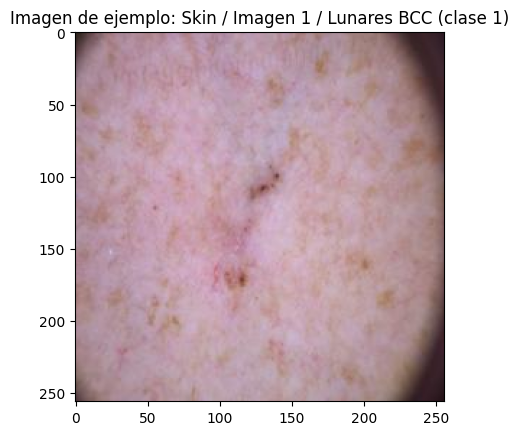

In [32]:
test_img = imageload(1,1)
plt.imshow(test_img, cmap='gray')
plt.title('Imagen de ejemplo: Skin / Imagen 1 / Lunares BCC (clase 1)')
plt.show()

# 2. Feature Extraction

In [ ]:
K = 5 # Cantidad de clases del dataset
N = 240 # Cantidad de imagenes por clase


# 3. Training and testing subsets

# 4. Classification

# 5. Evaluation